In [12]:
%matplotlib inline

from __future__ import division
import os
import tensorflow as tf
import numpy as np
from nets import vgg
from matplotlib import pyplot as plt
from scipy.misc import imread
from preprocessing import vgg_preprocessing
from libs.training import get_labels_from_annotation_batch
# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)
from os.path import join
slim = tf.contrib.slim

# Data processing

In [13]:
#0:   background
#1:   aeroplane
#2:   bicycle
#3:   bird
#4:   boat
#5:   bottle
#6:   bus
#7:   car
#8:   cat
#9:   chair
#10:  cow
#11:  diningtable
#12:  dog
#13:  horse
#14:  motorbike
#15:  person
#16:  pottedplant
#17:  sheep
#18:  sofa
#19:  train
#20:  tvmonitor
#255: undefined/don't care
number_of_classes = 3
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

In [14]:
def _mean_image_subtraction(image, means):
    """Subtracts the given means from each image channel.

    For example:
    means = [123.68, 116.779, 103.939]
    image = _mean_image_subtraction(image, means)

    Note that the rank of `image` must be known.

    Args:
    image: a tensor of size [height, width, C].
    means: a C-vector of values to subtract from each channel.

    Returns:
    the centered image.

    Raises:
    ValueError: If the rank of `image` is unknown, if `image` has a rank other
      than three or if the number of channels in `image` doesn't match the
      number of values in `means`.
    """
    if image.get_shape().ndims != 4:
        print("lkjgflkfdsjglkfdsjg")
        raise ValueError('Input must be of size [height, width, C>0]')
    num_channels = image.get_shape().as_list()[-1]
    
    if len(means) != num_channels:
        raise ValueError('len(means) must match the number of channels')

    channels = tf.split(axis=3, num_or_size_splits=num_channels, value=image)
    for i in range(num_channels):
        channels[i] -= means[i]
        
    return tf.concat(axis=3, values=channels)

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [15]:
checkpoints_dir = '/home/thalles/image-segmentation/vgg'
log_folder = '/home/thalles/log_folder'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [16]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    input_batch_plc = tf.placeholder(tf.float32, shape=(None, None, None, 3))
    input_masks_plc = tf.placeholder(tf.float32, shape=(None, None, None))
    return input_batch_plc, input_masks_plc, is_training_placeholder

### Loss function definition and training using Adam Optimization Algorithm.

In [17]:
def model(processed_images, number_of_classes=21, is_training=True):
    # Subtract the mean pixel value from each pixel
    processed_images = _mean_image_subtraction(processed_images,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])
    with slim.arg_scope(vgg.vgg_arg_scope()):
        _, end_points = vgg.vgg_16(processed_images,
                                         num_classes=number_of_classes,
                                         is_training=True,
                                         spatial_squeeze=False,
                                         scope='vgg_16')

        input_shape = tf.shape(processed_images)

        #vgg_fc6_feature = end_points['vgg_16/fc6']
        
        # get the vggs pool5 feature map
        pool5_feature_map = end_points['vgg_16/pool5']
        pool5_feature_shape = tf.shape(pool5_feature_map)

        pool4_feature_map = end_points['vgg_16/pool4']
        pool4_feature_shape = tf.shape(pool4_feature_map)

        pool3_feature_map = end_points['vgg_16/pool3']
        pool3_feature_shape = tf.shape(pool3_feature_map)

        pool2_feature_map = end_points['vgg_16/pool2']
        pool2_feature_shape = tf.shape(pool2_feature_map)

        pool1_feature_map = end_points['vgg_16/pool1']
        pool1_feature_shape = tf.shape(pool1_feature_map)

        with tf.variable_scope("seg_vars"):
            
            # Merging Pooling 4 layer
            pool5_feature_resized = tf.image.resize_images(pool5_feature_map, 
                                                           [pool4_feature_shape[1],pool4_feature_shape[2]], method=0)
            pool5_feature_conv = slim.conv2d(pool5_feature_resized, 512, [3, 3], activation_fn=None)

            pool4_feature_conv = slim.conv2d(pool4_feature_map,
                                   512,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool5_conv_plus_poo4_conv = pool5_feature_conv + pool4_feature_conv
            
            # Merging Pooling 3 layer
            pool4_feature_resized = tf.image.resize_images(pool5_conv_plus_poo4_conv, 
                                                           (pool3_feature_shape[1], pool3_feature_shape[2]), method=0)
            pool4_feature_conv = slim.conv2d(pool4_feature_resized, 256, [3, 3], activation_fn=None)
            #pool4_feature_conv = tf.contrib.layers.batch_norm(pool4_feature_conv)
            
            pool3_feature_conv = slim.conv2d(pool3_feature_map,
                                   256,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool4_conv_plus_pool3_conv = pool4_feature_conv + pool3_feature_conv

            # Merging Pooling 2 layer
            pool3_feature_resized = tf.image.resize_images(pool4_conv_plus_pool3_conv, 
                                                           (pool2_feature_shape[1], pool2_feature_shape[2]), method=0)
            pool3_feature_conv = slim.conv2d(pool3_feature_resized, 128, [3, 3], activation_fn=None)
            #pool3_feature_conv = tf.contrib.layers.batch_norm(pool3_feature_conv)
            
            pool2_feature_conv = slim.conv2d(pool2_feature_map,
                                   128,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool3_conv_plus_pool2_conv = pool3_feature_conv + pool2_feature_conv

            # Merging Pooling1 layer
            pool2_feature_resized = tf.image.resize_images(pool3_conv_plus_pool2_conv, 
                                                           (pool1_feature_shape[1], pool1_feature_shape[2]), method=0)
            pool2_feature_conv = slim.conv2d(pool2_feature_resized, 64, [3, 3], activation_fn=None)
            #pool2_feature_conv = tf.contrib.layers.batch_norm(pool2_feature_conv)
            
            pool1_feature_conv = slim.conv2d(pool1_feature_map,
                                   64,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer)

            pool2_conv_plus_pool1_conv = pool2_feature_conv + pool1_feature_conv
            
            # Resize to original image shape
            orignal_image_shape = tf.image.resize_images(pool2_conv_plus_pool1_conv, 
                                                           (input_shape[1], input_shape[2]), method=0)
            orignal_image_conv = slim.conv2d(orignal_image_shape, 64, [3, 3], activation_fn=None)
            
            orignal_image_logits = slim.conv2d(orignal_image_conv, number_of_classes, [3, 3], activation_fn=None)
            return orignal_image_logits

In [18]:
def model_loss(upsampled_by_factor_16_logits, labels, class_labels):
    
    labels = get_labels_from_annotation_batch(labels, class_labels)
    
    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=upsampled_by_factor_16_logits,
                                                              labels=labels)

    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [19]:
def model_optimizer(cross_entropy_sum, learning_rate):
    # Here we define an optimizer and put all the variables
    # that will be created under a namespace of 'adam_vars'.
    # This is done so that we can easily access them later.
    # Those variables are used by adam optimizer and are not
    # related to variables of the vgg model.

    # We also retrieve gradient Tensors for each of our variables
    # This way we can later visualize them in tensorboard.
    # optimizer.compute_gradients and optimizer.apply_gradients
    # is equivalent to running:
    # train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
    with tf.variable_scope("adam_vars"):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_sum)
    return train_step

In [20]:
input_shape = (384,384,3)
annotation_shape = (384,384)
total_epochs = 30
batch_size = 20
image_size=[384, 384]
total_train_steps = 50

In [21]:
base_dataset_dir = "./"
train_images_dir = join(base_dataset_dir, "images/")
train_annotations_dir = join(base_dataset_dir, "labels/")

In [22]:
image_name = "22678915_15"
crop_size = 384

In [23]:
def read_image_and_annotation(train_images_dir, train_annotations_dir, image_name):
    # read the input and annotation images
    image = imread(train_images_dir + image_name + ".png")
    annotation = imread(train_annotations_dir + image_name + ".png")
    assert (image.dtype) == "uint8"
    assert (annotation.dtype) == "uint8"
    return image, annotation

In [24]:
def random_crop(image_np, annotation_np, crop_size=128):
    """
    image_np: rgb image shape (H,W,3)
    annotation_np: 1D image shape (H,W,1)
    crop_size: integer
    """
    image_h = image_np.shape[0]
    image_w = image_np.shape[1]
    
    random_x = np.random.randint(0, image_w-crop_size+1) # Return random integers from low (inclusive) to high (exclusive).
    random_y = np.random.randint(0, image_h-crop_size+1) # Return random integers from low (inclusive) to high (exclusive).
    
    offset_x = random_x + crop_size
    offset_y = random_y + crop_size
    
    return image_np[random_x:offset_x, random_y:offset_y,:], annotation_np[random_x:offset_x, random_y:offset_y]

In [25]:
file = open("train.txt", 'r')
images_filenale_list = [line for line in file]

In [26]:
def next_batch(train_images_dir, train_annotations_dir, image_filenames_list, batch_size=5, crop_size=128):
    
    for image_name in image_filenames_list:
        
        image_np, annotation_np = read_image_and_annotation(train_images_dir, train_annotations_dir, image_name)
            
        batch_images = None
        batch_labels = None
        
        for batch_i in range(batch_size):
            cropped_image, cropped_annotation = random_crop(image_np, annotation_np, crop_size)
            cropped_image = np.expand_dims(cropped_image, axis=0)
            cropped_annotation = np.expand_dims(cropped_annotation, axis=0)
            
            if batch_images is None:
                batch_images = cropped_image
                batch_labels = cropped_annotation
            else:
                #print(batch_images.shape, cropped_image.shape)
                batch_images = np.concatenate((batch_images, cropped_image), axis=0)
                batch_labels = np.concatenate((batch_labels, cropped_annotation), axis=0)
    
        yield batch_images, batch_labels

In [27]:
input_batch_plc, input_masks_plc, is_training_placeholder = model_input()

upsampled_by_factor_16_logits = model(input_batch_plc, number_of_classes=number_of_classes, is_training=True)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, input_masks_plc, class_labels)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.000004)

In [28]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles/image-segmentation/vgg/vgg_16.ckpt
Train step: 0 	Traing Loss: 17.6811


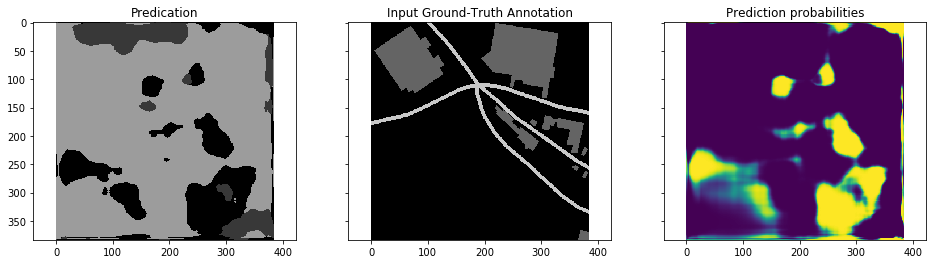

Train step: 1 	Traing Loss: 5.24331


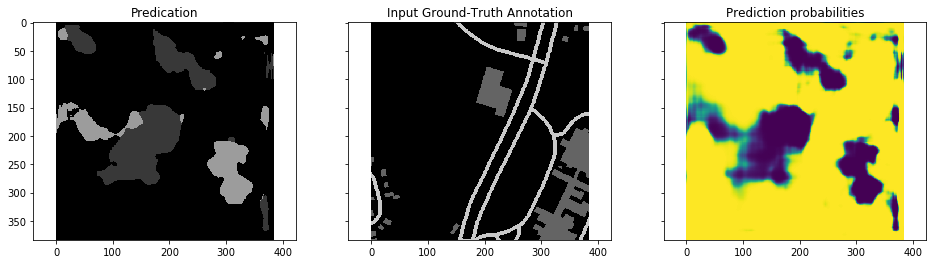

Train step: 2 	Traing Loss: 6.76408


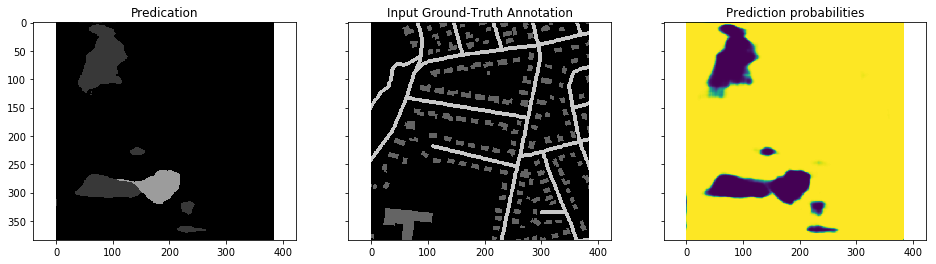

Train step: 3 	Traing Loss: 7.58917


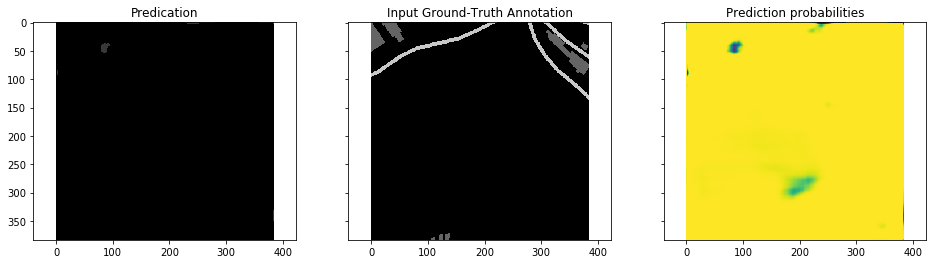

Train step: 4 	Traing Loss: 9.25441


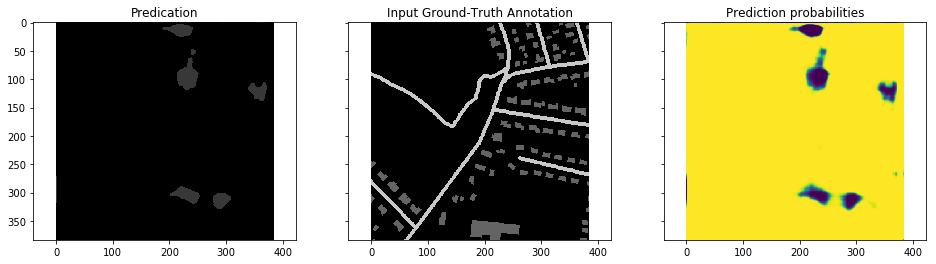

Train step: 5 	Traing Loss: 7.08456


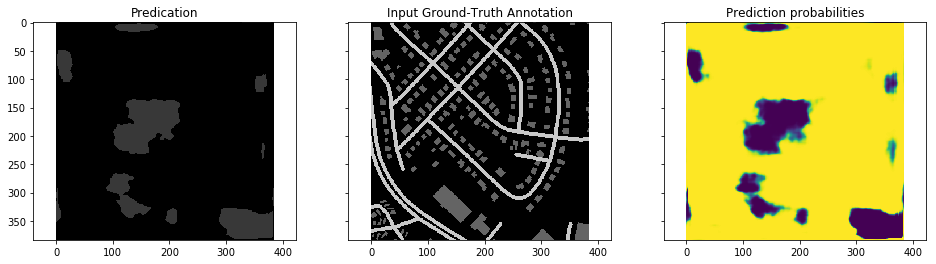

Train step: 6 	Traing Loss: 7.16652


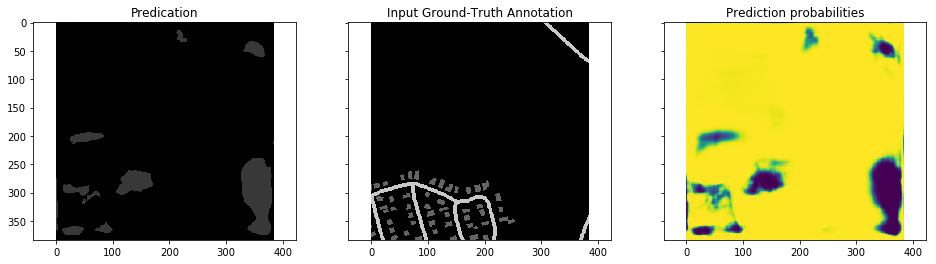

Train step: 7 	Traing Loss: 6.93665


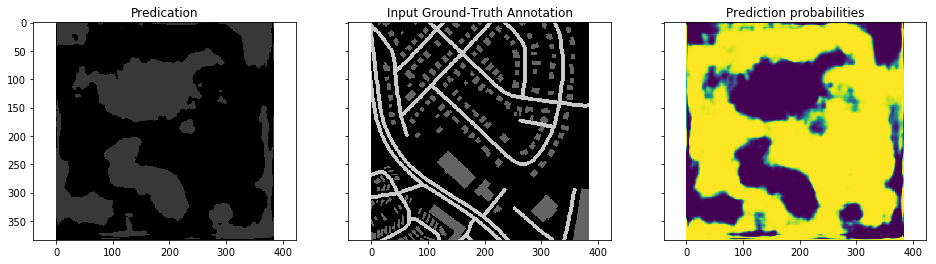

Train step: 8 	Traing Loss: 5.67588


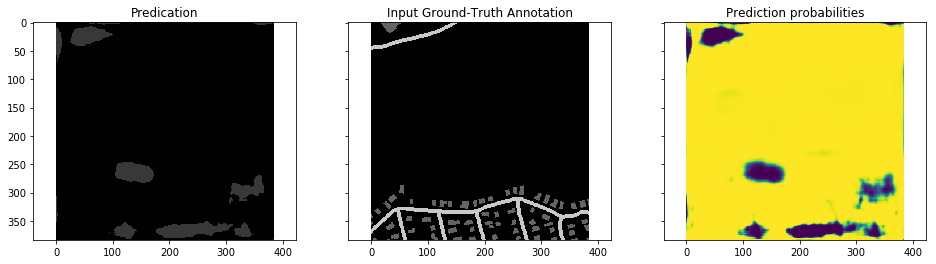

Train step: 9 	Traing Loss: 5.77971


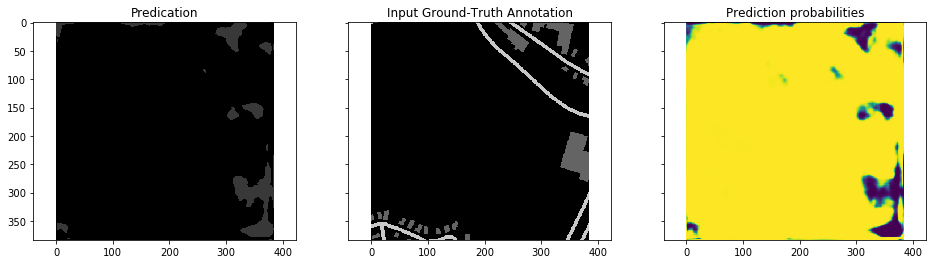

Train step: 10 	Traing Loss: 4.33439


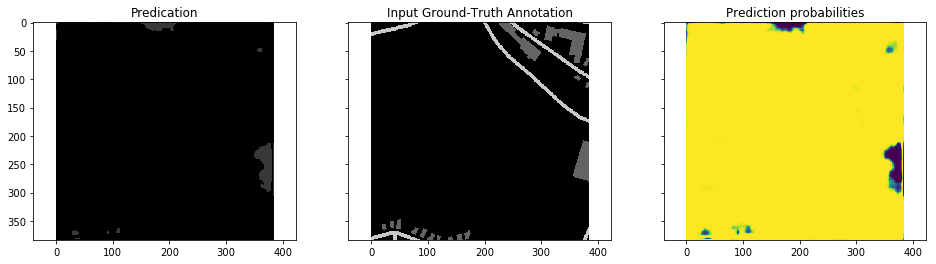

Train step: 11 	Traing Loss: 3.75937


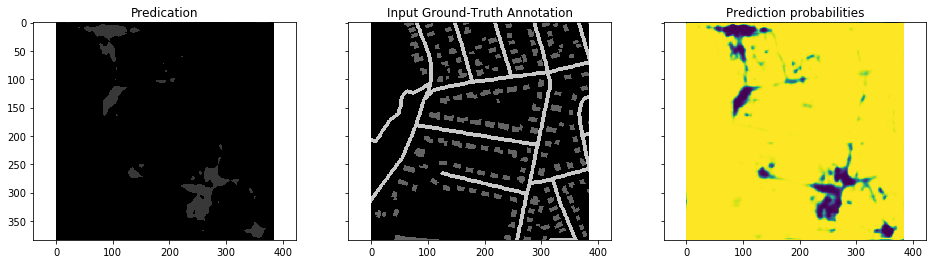

Train step: 12 	Traing Loss: 3.08284


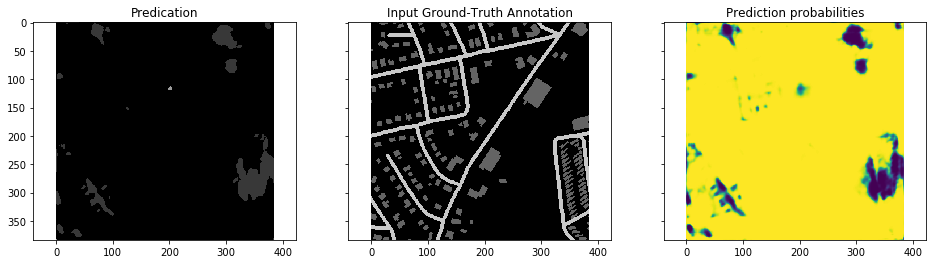

Train step: 13 	Traing Loss: 2.26685


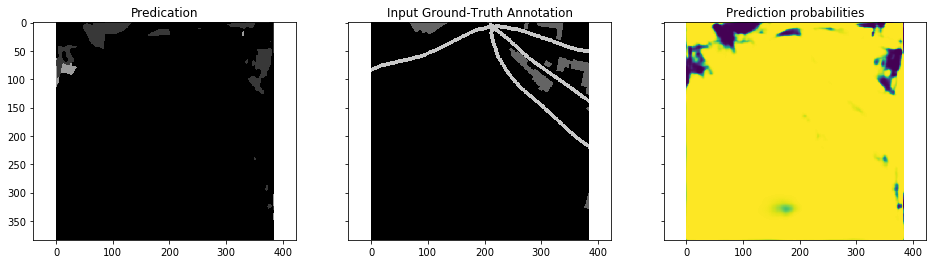

Train step: 14 	Traing Loss: 1.90615


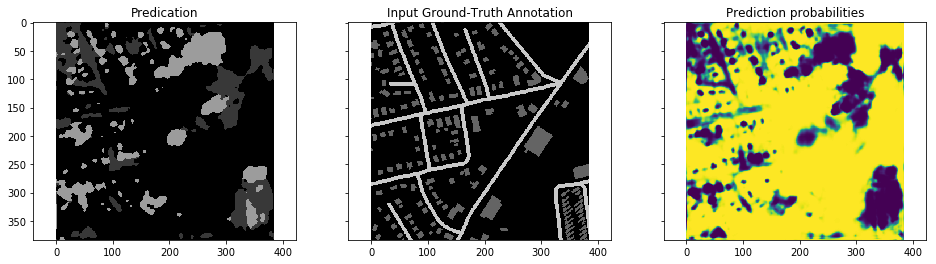

Train step: 15 	Traing Loss: 2.56111


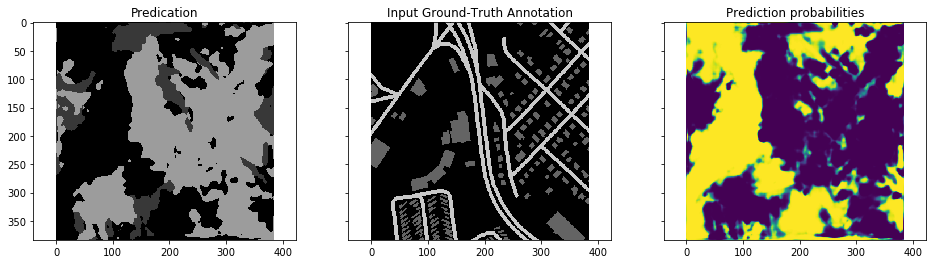

Train step: 16 	Traing Loss: 3.23647


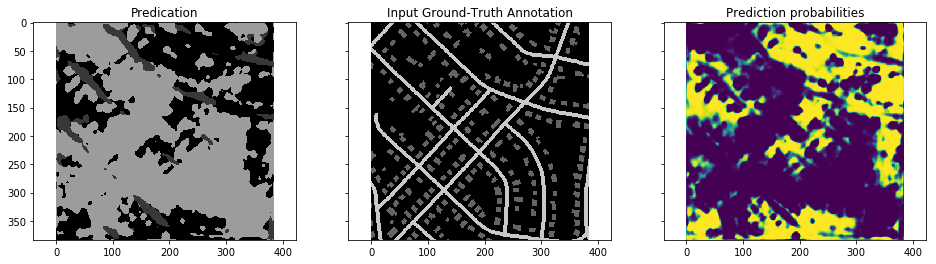

Train step: 17 	Traing Loss: 2.73074


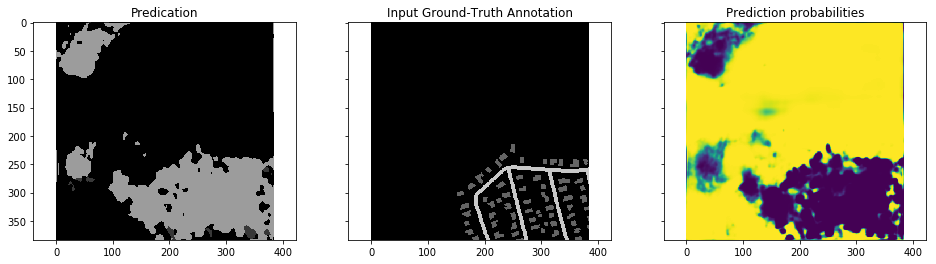

Train step: 18 	Traing Loss: 1.65886


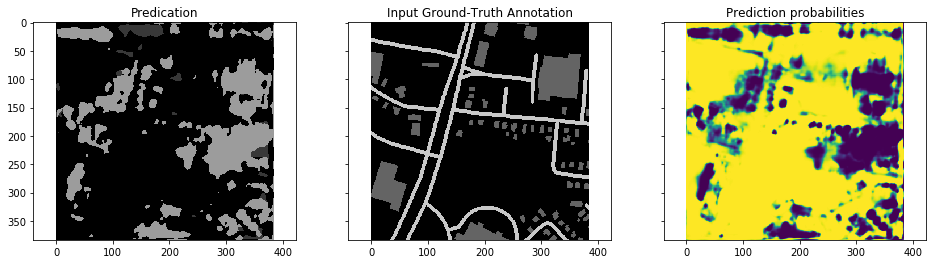

Train step: 19 	Traing Loss: 1.3975


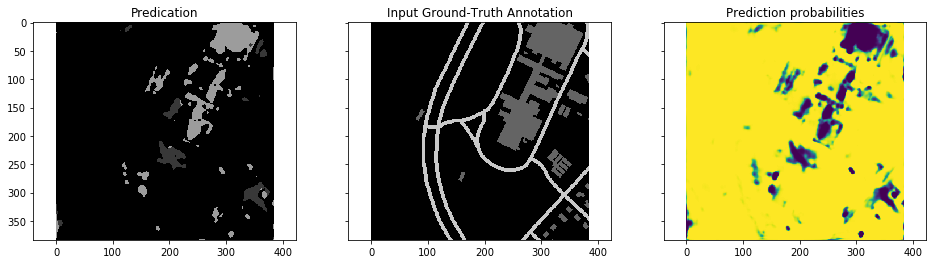

Train step: 20 	Traing Loss: 1.70255


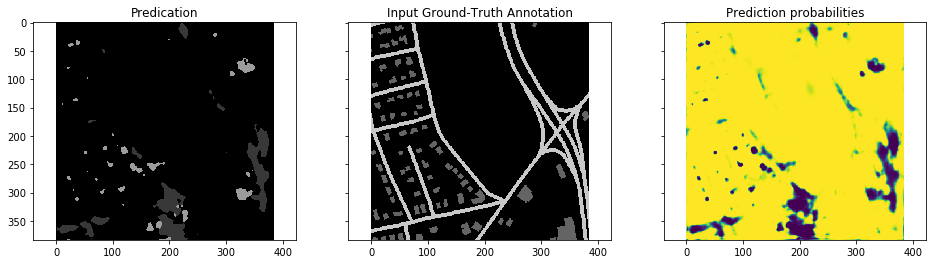

Train step: 21 	Traing Loss: 1.48286


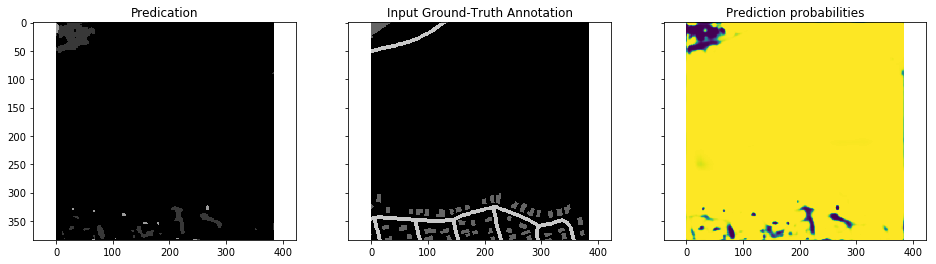

Train step: 22 	Traing Loss: 1.92494


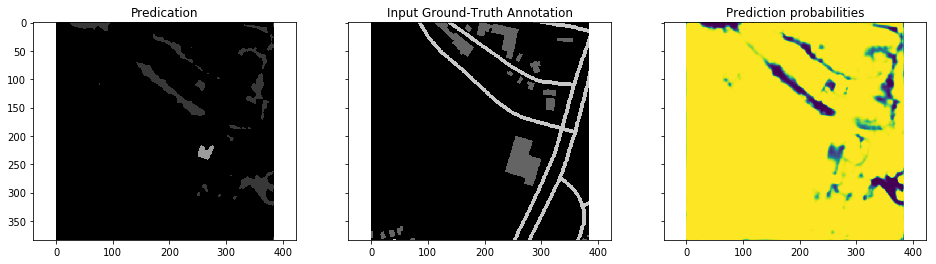

Train step: 23 	Traing Loss: 1.95746


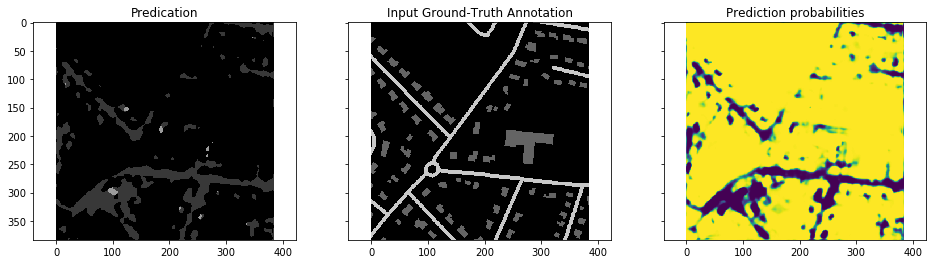

Train step: 24 	Traing Loss: 1.84537


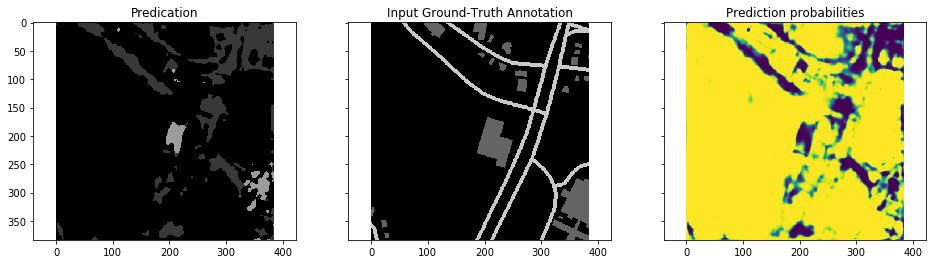

Train step: 25 	Traing Loss: 1.64436


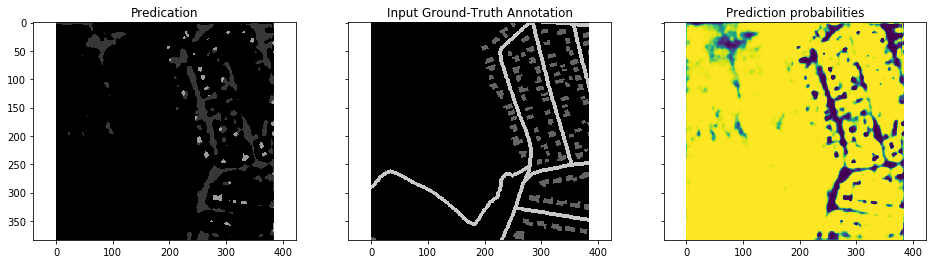

Train step: 26 	Traing Loss: 1.20961


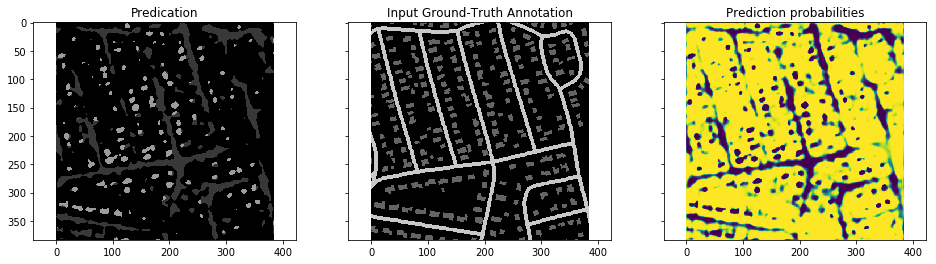

Train step: 27 	Traing Loss: 1.03597


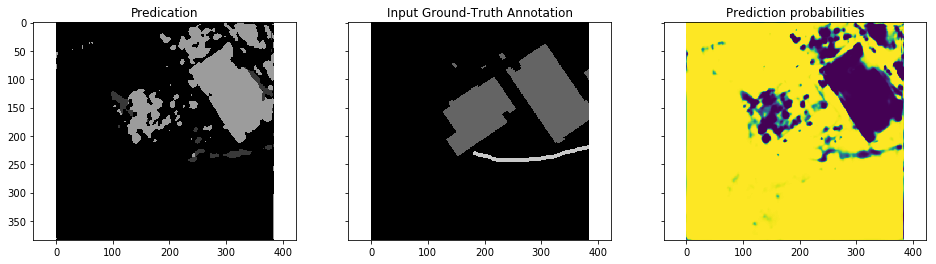

Train step: 28 	Traing Loss: 0.967534


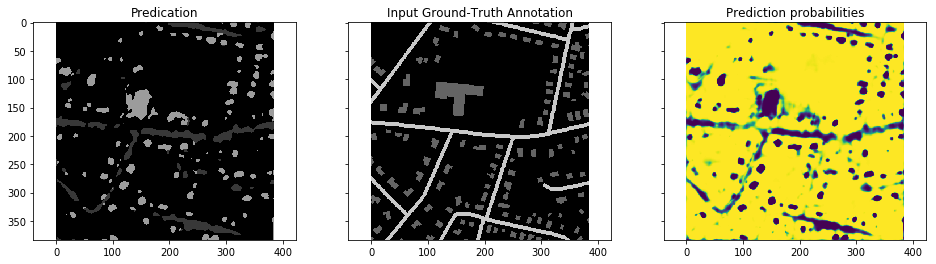

Train step: 29 	Traing Loss: 1.07062


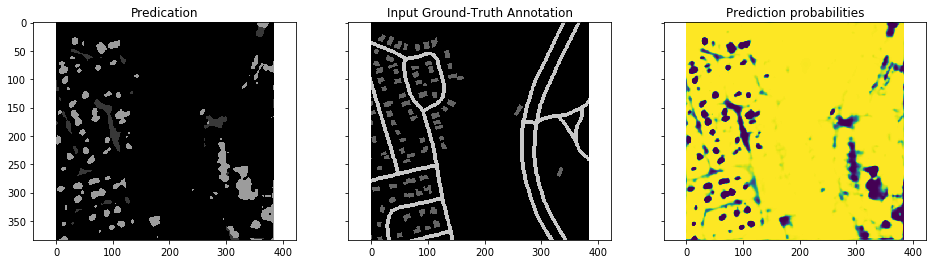

Train step: 30 	Traing Loss: 1.32444


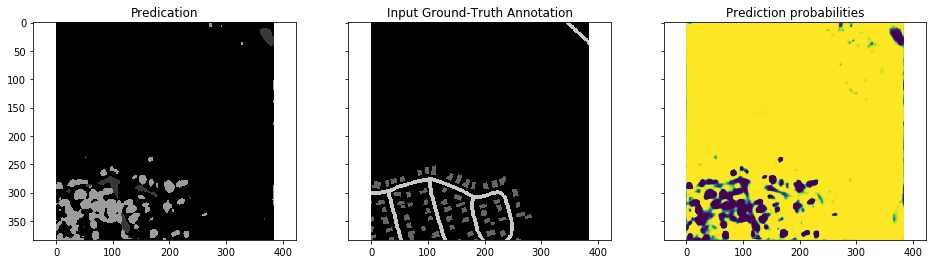

Train step: 31 	Traing Loss: 1.21852


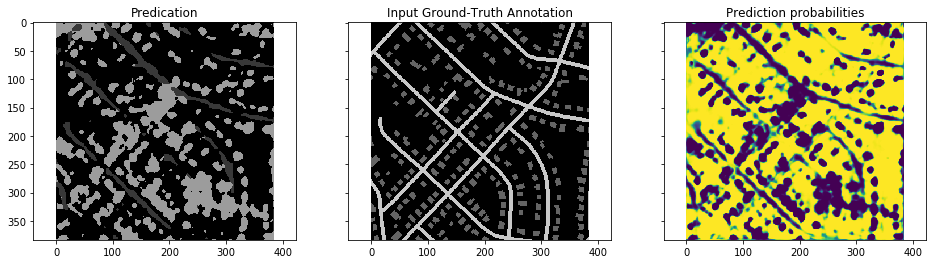

Train step: 32 	Traing Loss: 1.07724


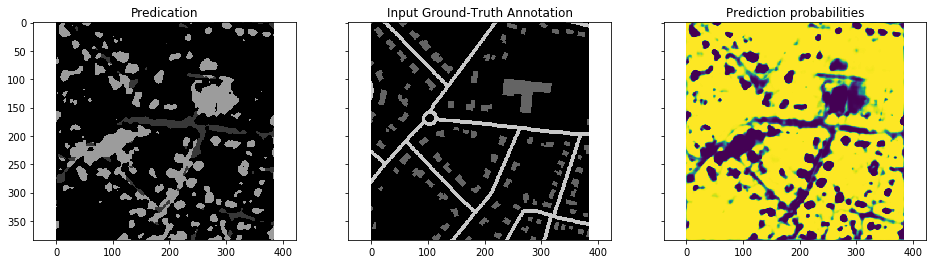

Train step: 33 	Traing Loss: 0.927625


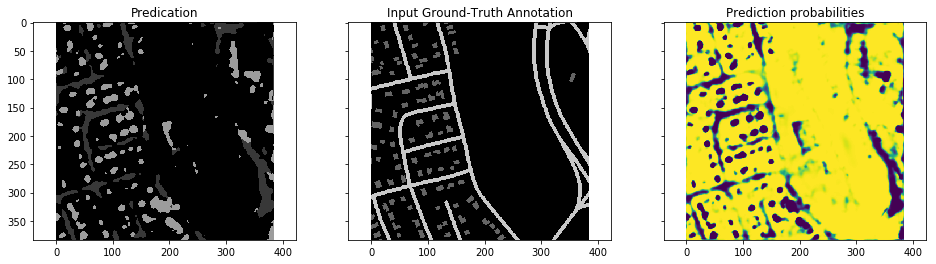

Train step: 34 	Traing Loss: 0.94515


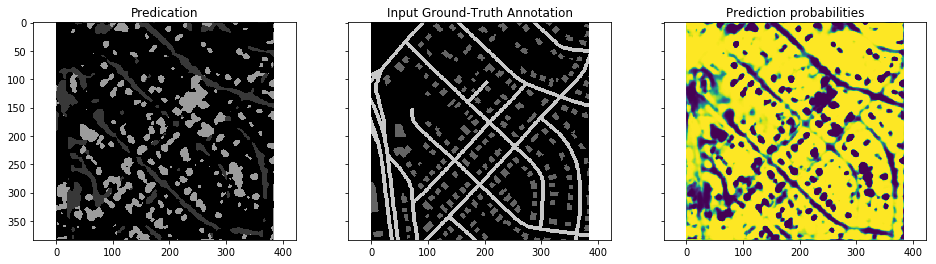

Train step: 35 	Traing Loss: 0.877449


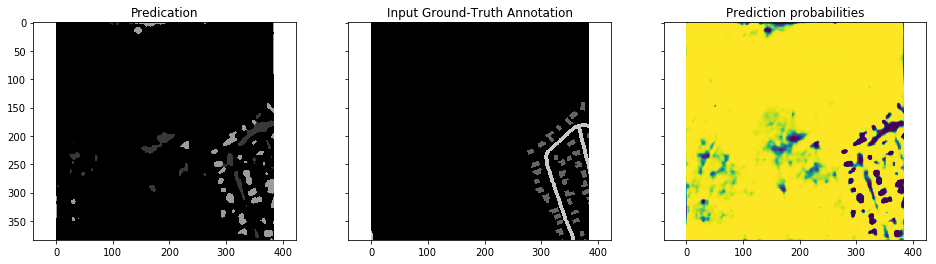

Train step: 36 	Traing Loss: 0.888753


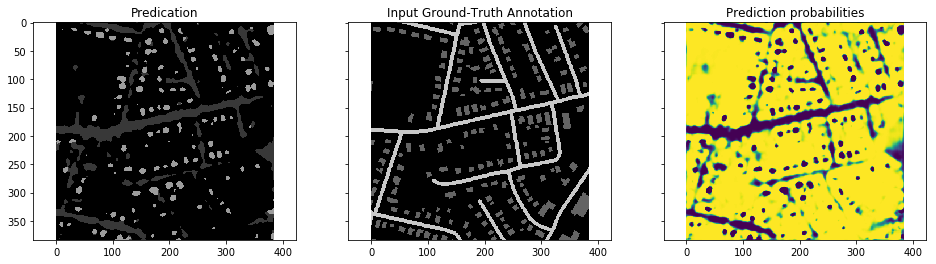

Train step: 37 	Traing Loss: 0.903548


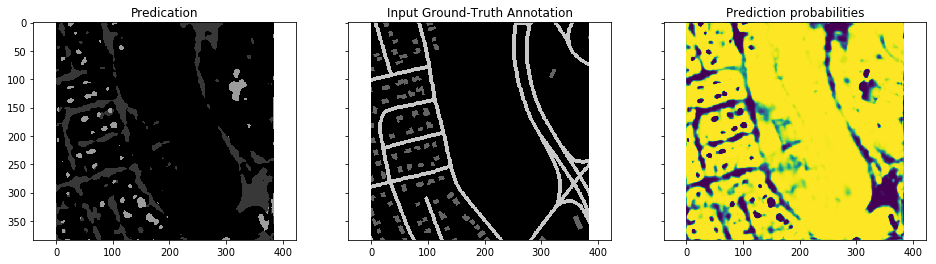

Train step: 38 	Traing Loss: 0.83643


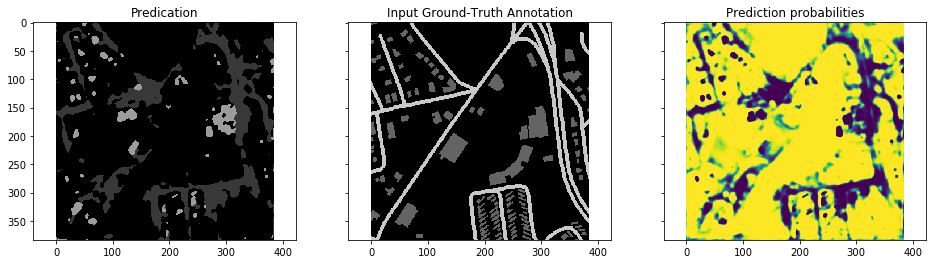

Train step: 39 	Traing Loss: 0.898266


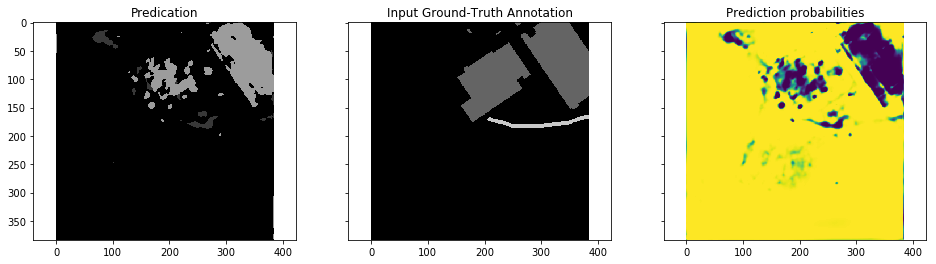

Train step: 40 	Traing Loss: 0.869843


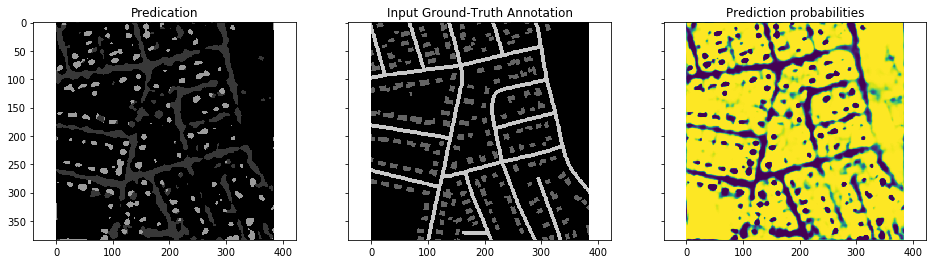

Train step: 41 	Traing Loss: 0.803441


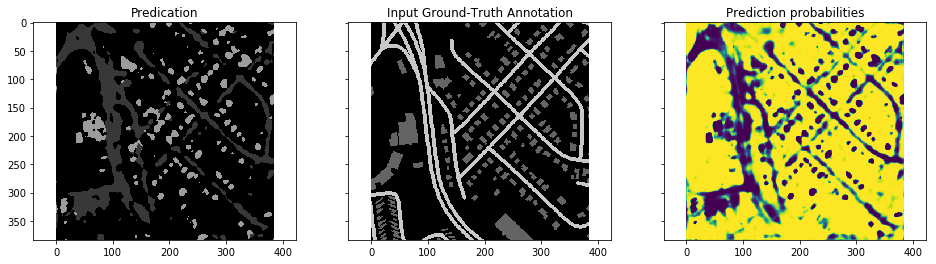

Train step: 42 	Traing Loss: 0.678505


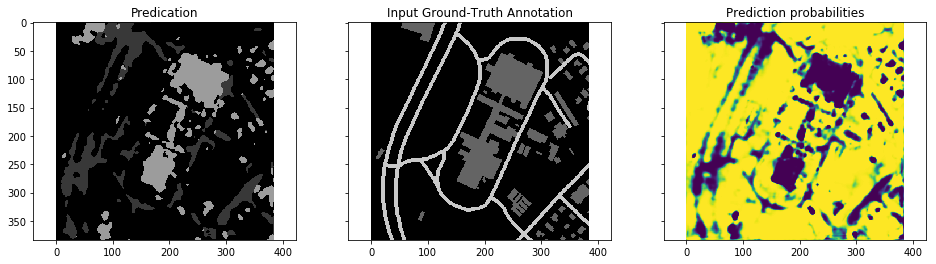

Train step: 43 	Traing Loss: 0.722652


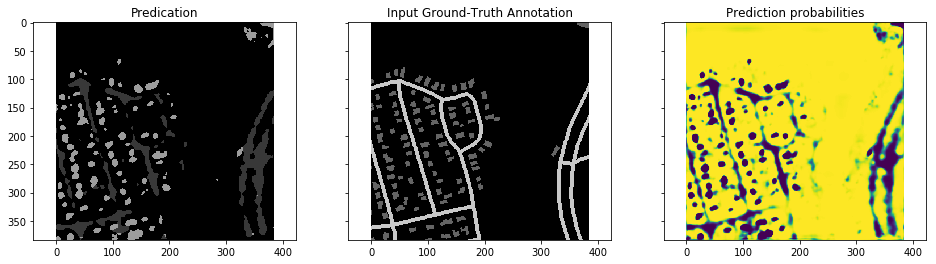

Train step: 44 	Traing Loss: 0.639578


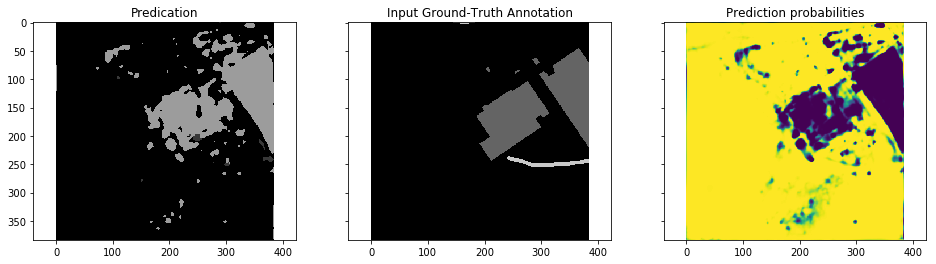

Train step: 45 	Traing Loss: 0.748953


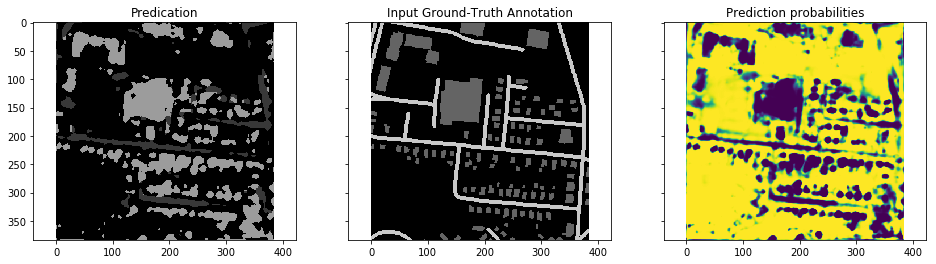

Train step: 46 	Traing Loss: 0.707621


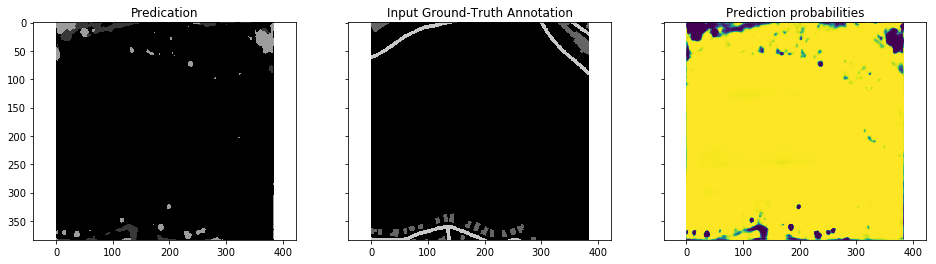

Train step: 47 	Traing Loss: 0.705304


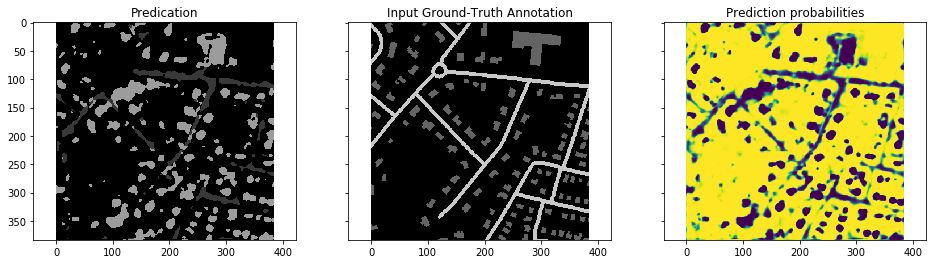

Train step: 48 	Traing Loss: 0.639964


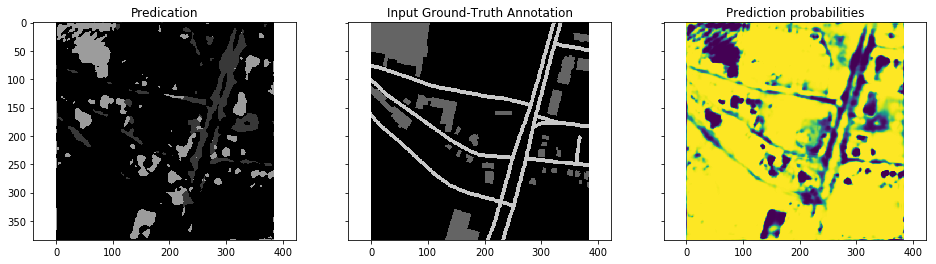

Train step: 49 	Traing Loss: 0.597015


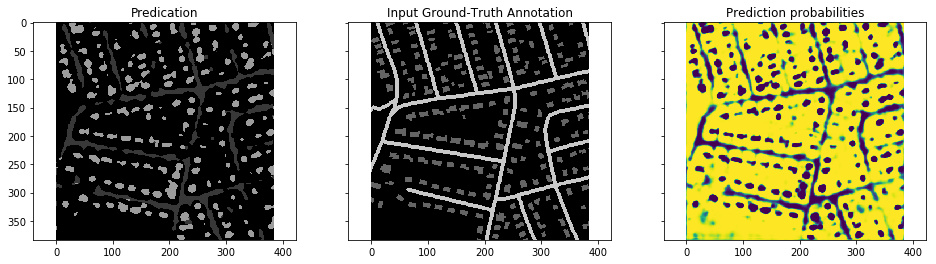

Train step: 50 	Traing Loss: 0.695366


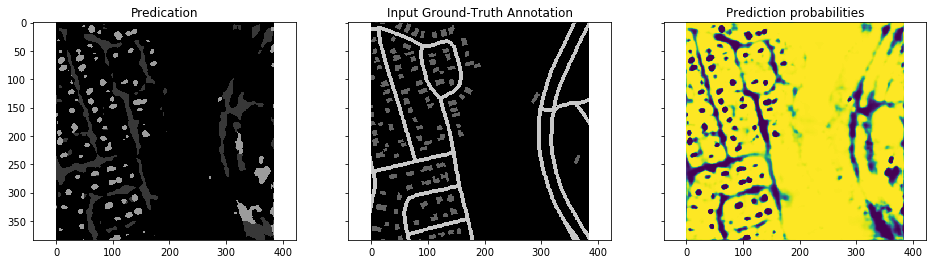

Train step: 51 	Traing Loss: 0.636601


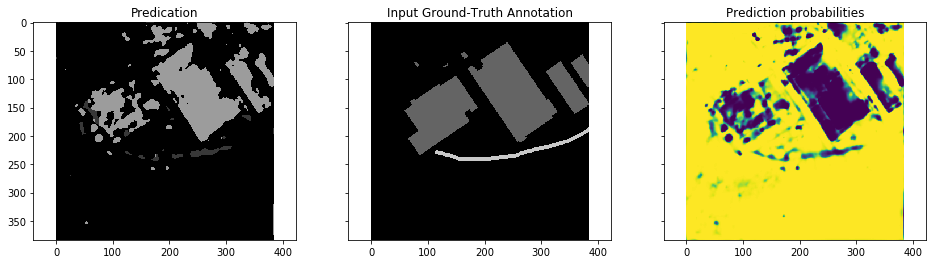

Train step: 52 	Traing Loss: 0.642659


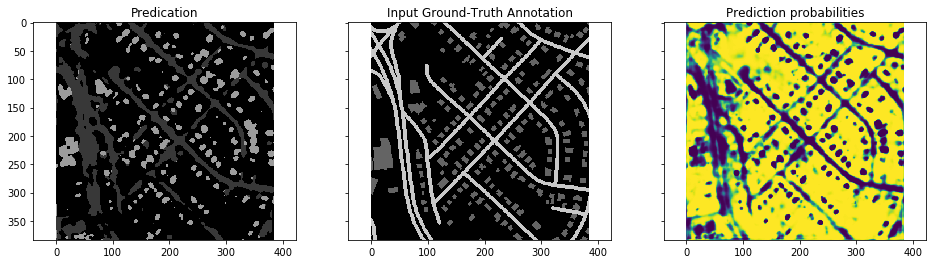

Train step: 53 	Traing Loss: 0.53117


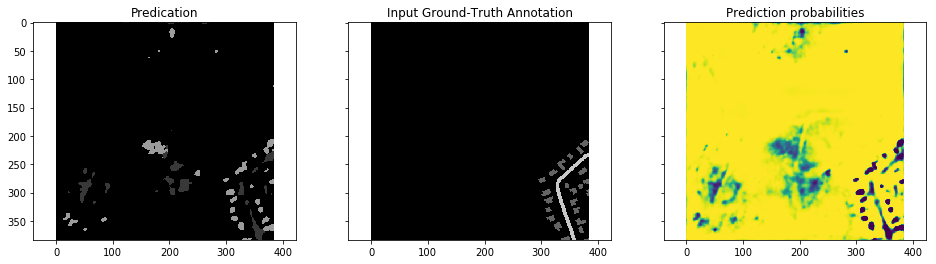

Train step: 54 	Traing Loss: 0.60828


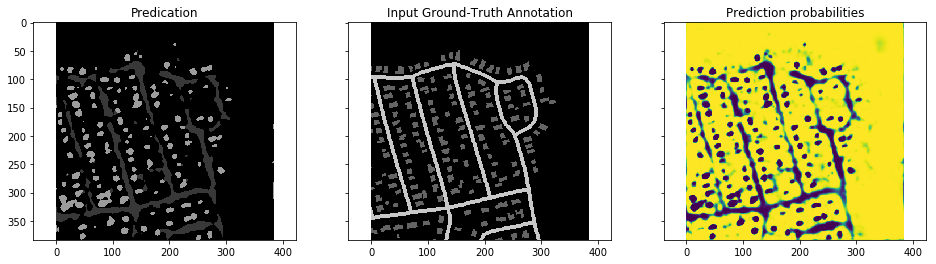

Train step: 55 	Traing Loss: 0.566306


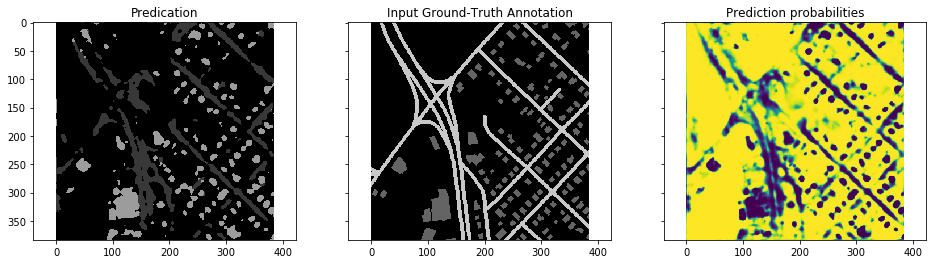

Train step: 56 	Traing Loss: 0.518632


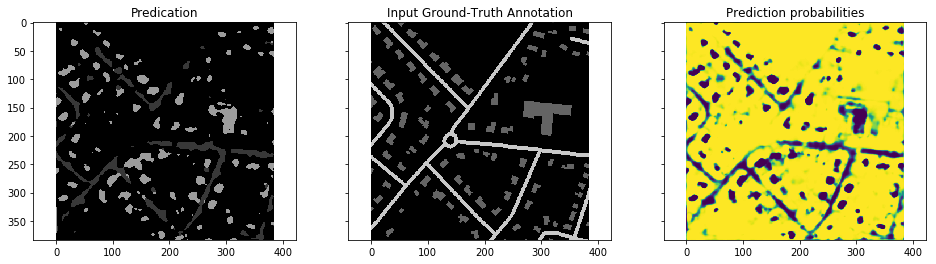

Train step: 57 	Traing Loss: 0.564905


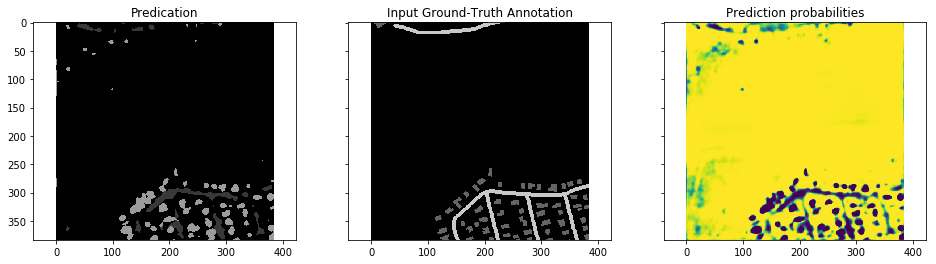

Train step: 58 	Traing Loss: 0.51306


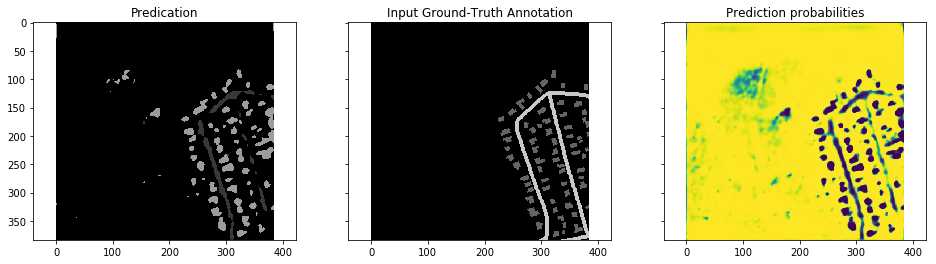

Train step: 59 	Traing Loss: 0.524846


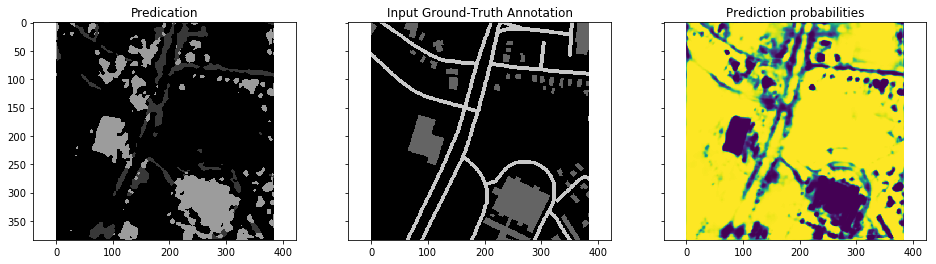

Train step: 60 	Traing Loss: 0.619379


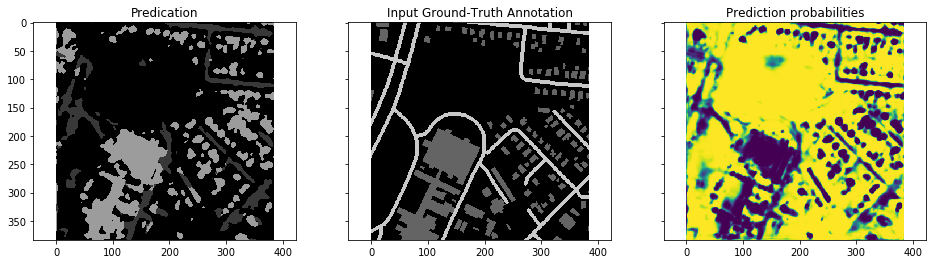

Train step: 61 	Traing Loss: 0.514746


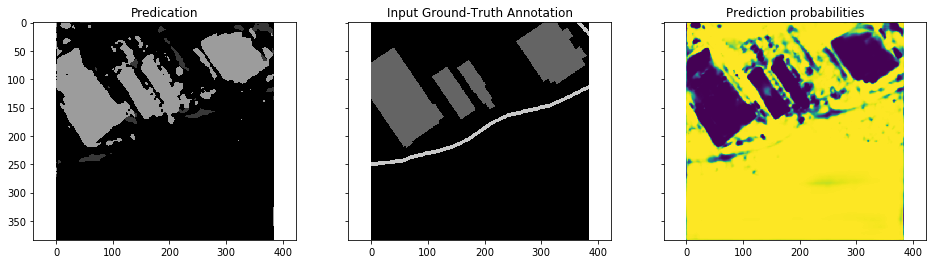

Train step: 62 	Traing Loss: 0.496337


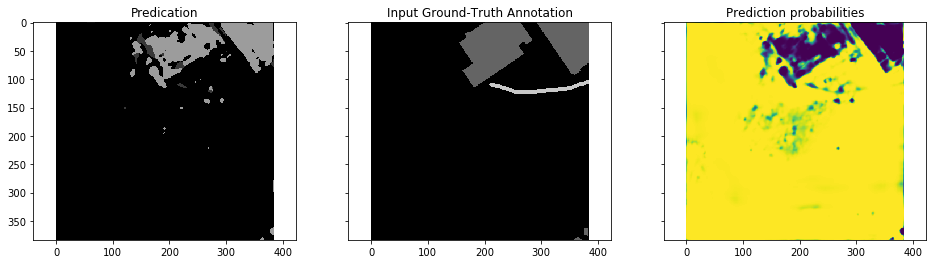

Train step: 63 	Traing Loss: 0.434512


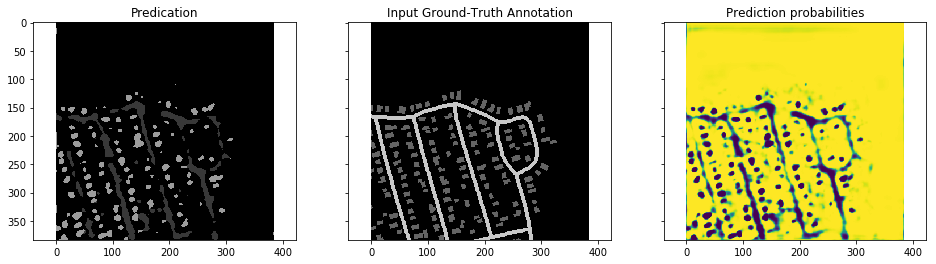

Train step: 64 	Traing Loss: 0.511308


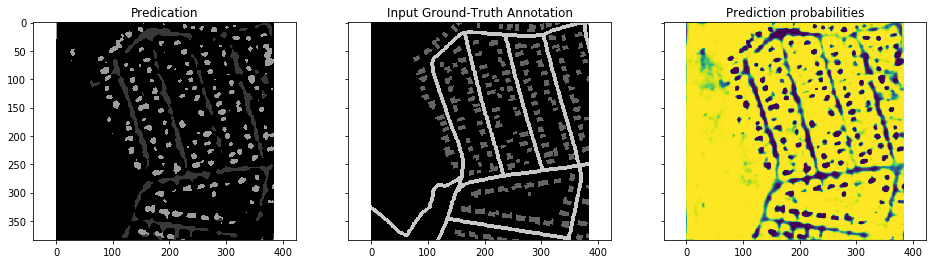

Train step: 65 	Traing Loss: 0.515775


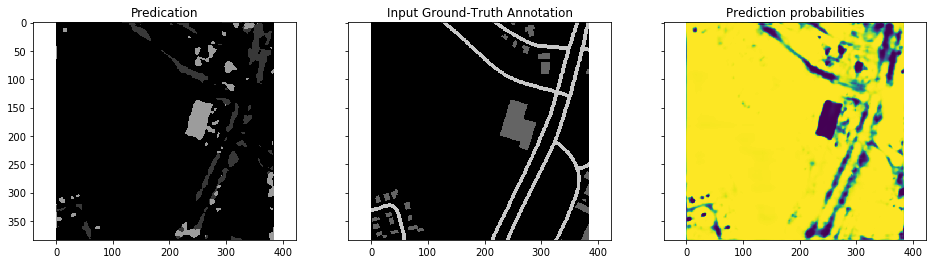

Train step: 66 	Traing Loss: 0.49148


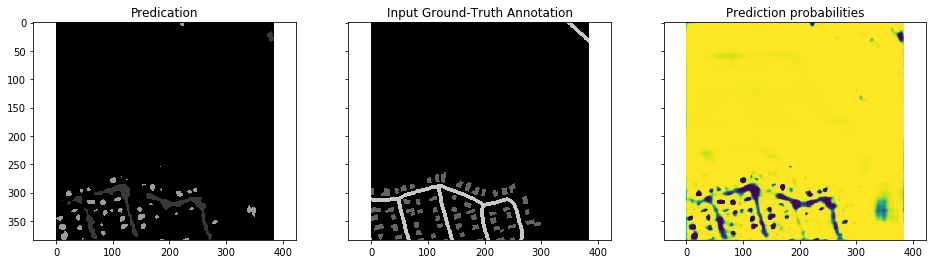

Train step: 67 	Traing Loss: 0.450934


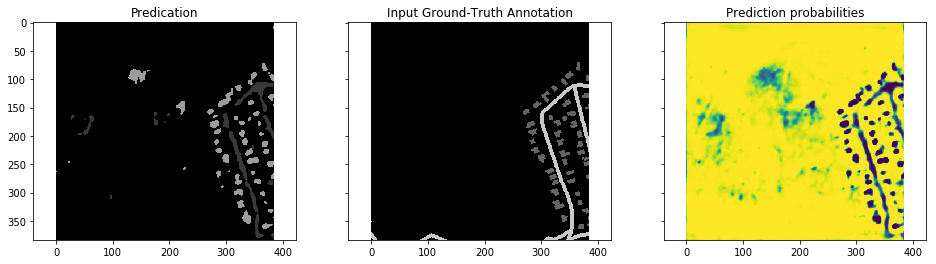

Train step: 68 	Traing Loss: 0.504292


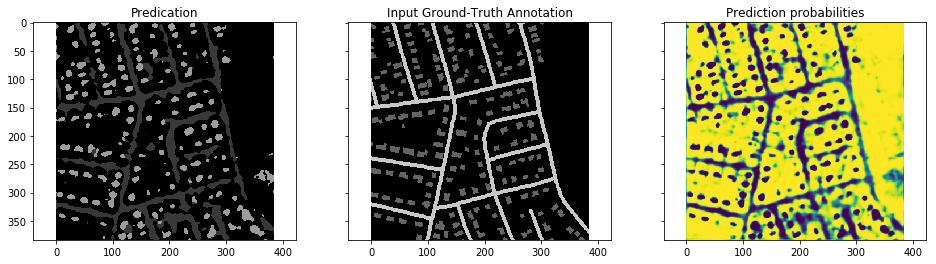

Train step: 69 	Traing Loss: 0.440813


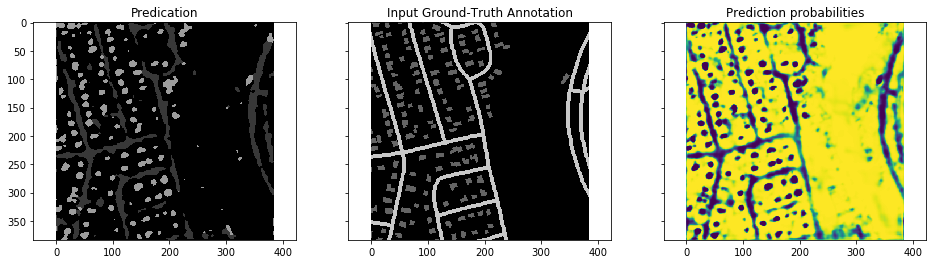

Train step: 70 	Traing Loss: 0.39021


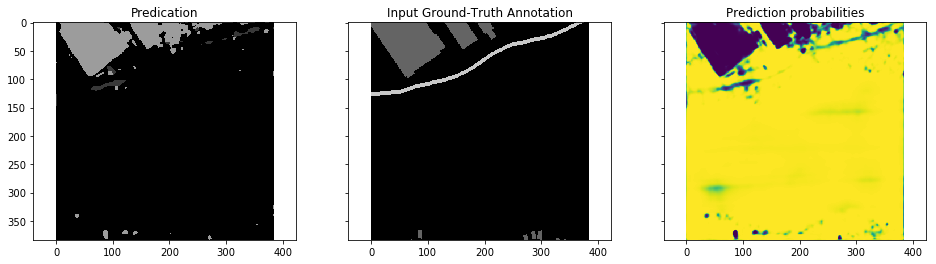

Train step: 71 	Traing Loss: 0.435384


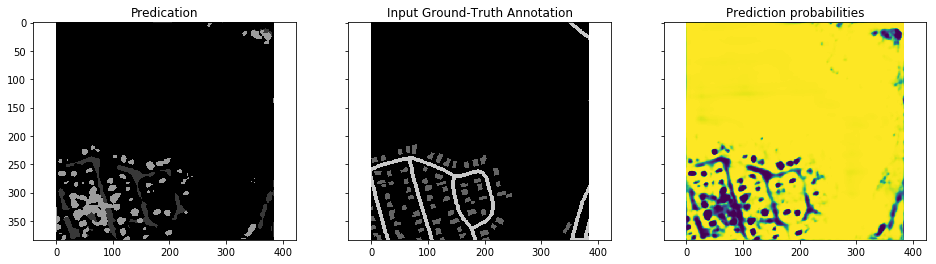

Train step: 72 	Traing Loss: 0.479861


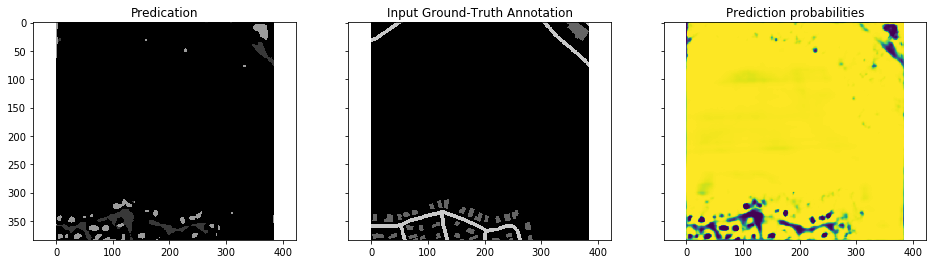

Train step: 73 	Traing Loss: 0.392696


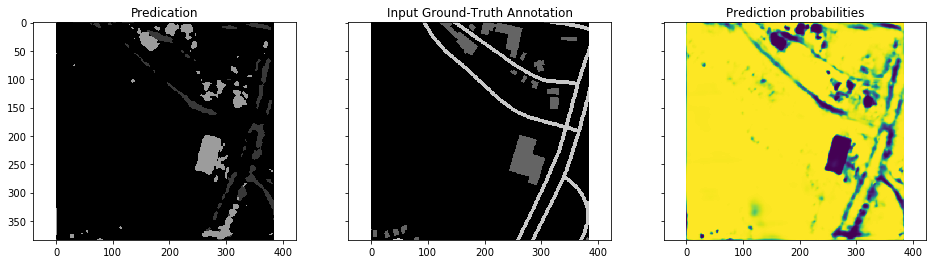

Train step: 74 	Traing Loss: 0.408741


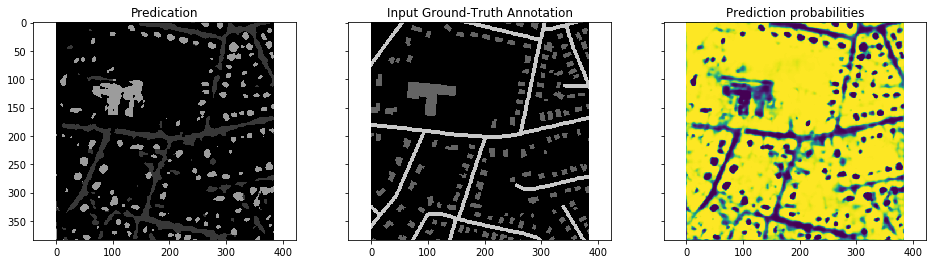

Train step: 75 	Traing Loss: 0.439977


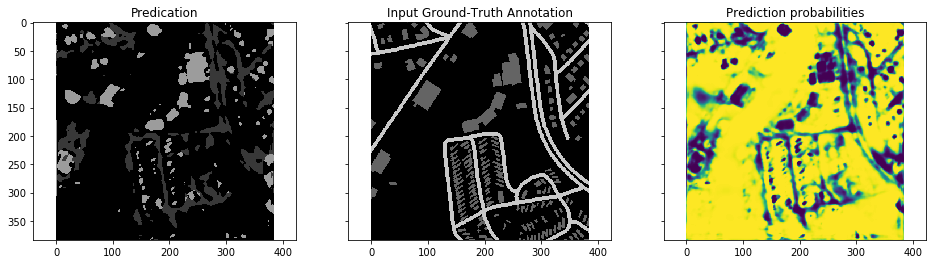

Train step: 76 	Traing Loss: 0.366727


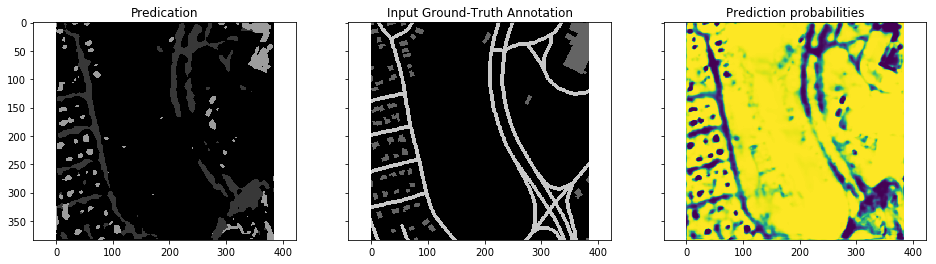

Train step: 77 	Traing Loss: 0.42107


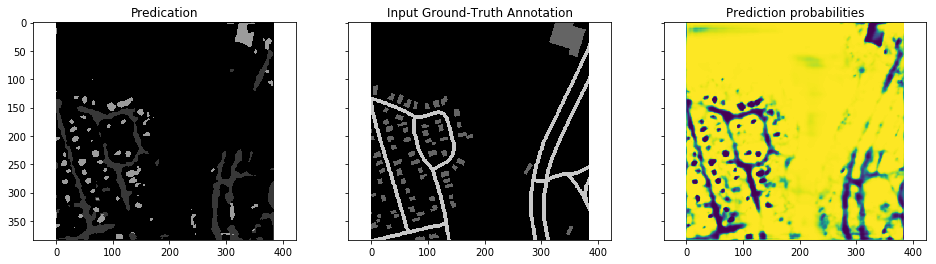

Train step: 78 	Traing Loss: 0.343132


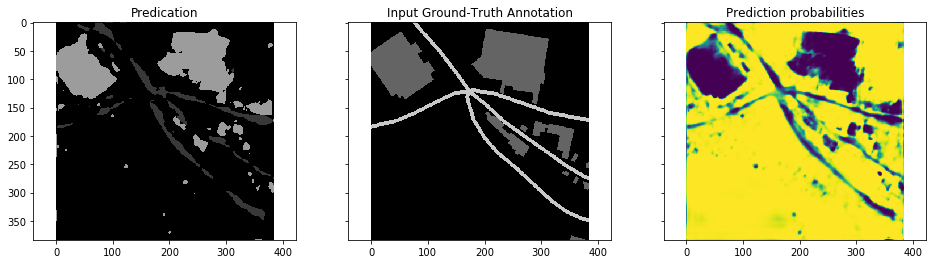

Train step: 79 	Traing Loss: 0.395555


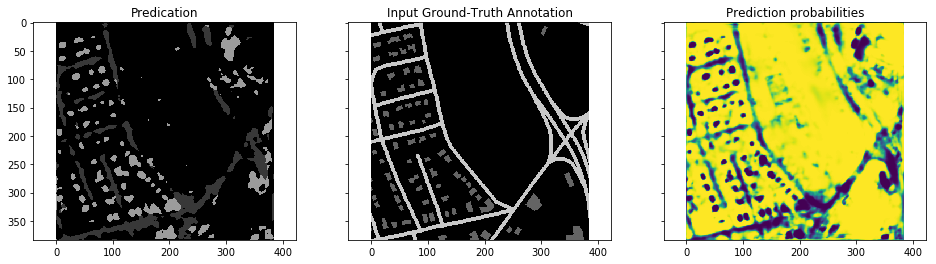

Train step: 80 	Traing Loss: 0.404572


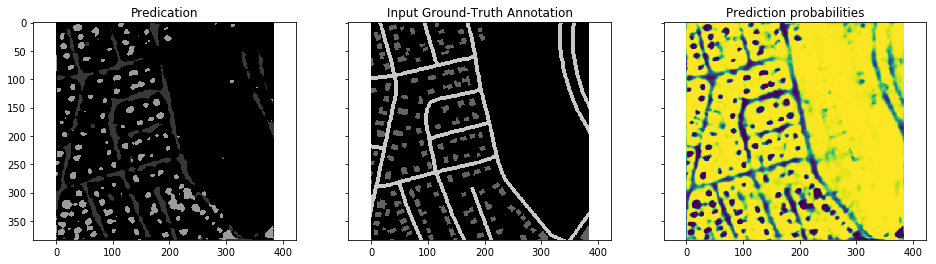

Train step: 81 	Traing Loss: 0.408379


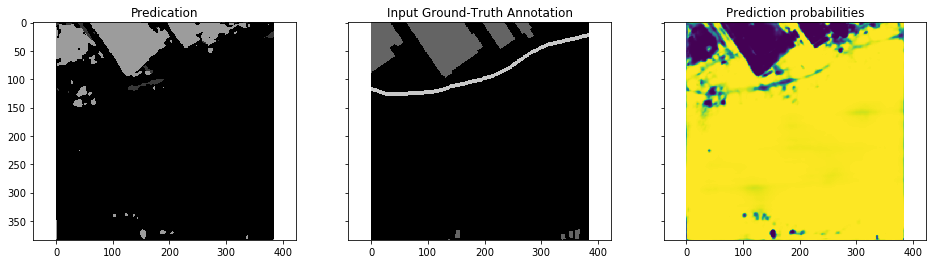

Train step: 82 	Traing Loss: 0.377027


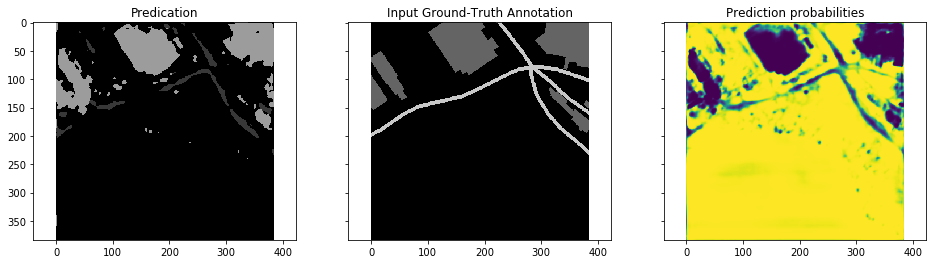

Train step: 83 	Traing Loss: 0.426754


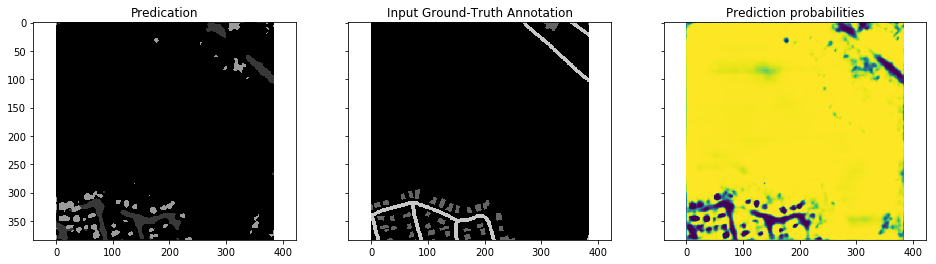

Train step: 84 	Traing Loss: 0.386797


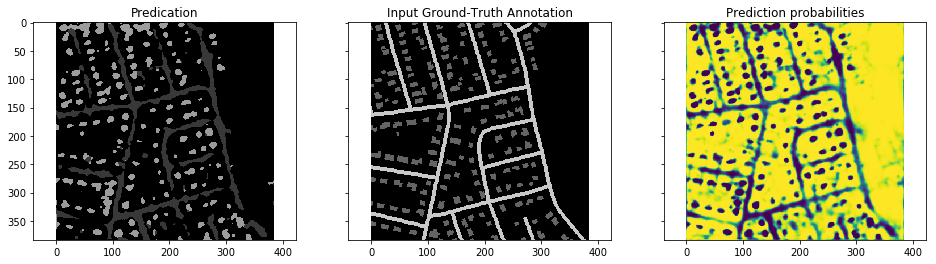

Train step: 85 	Traing Loss: 0.390784


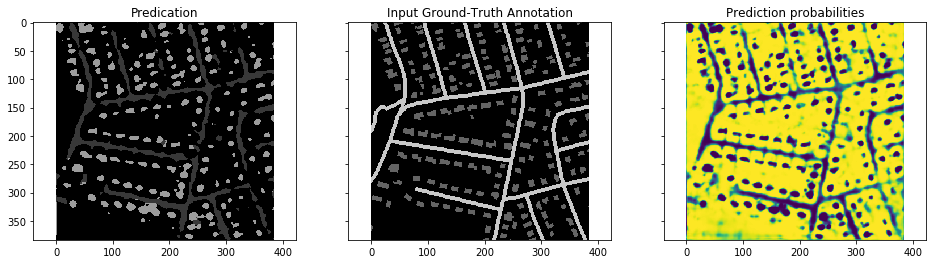

Train step: 86 	Traing Loss: 0.321636


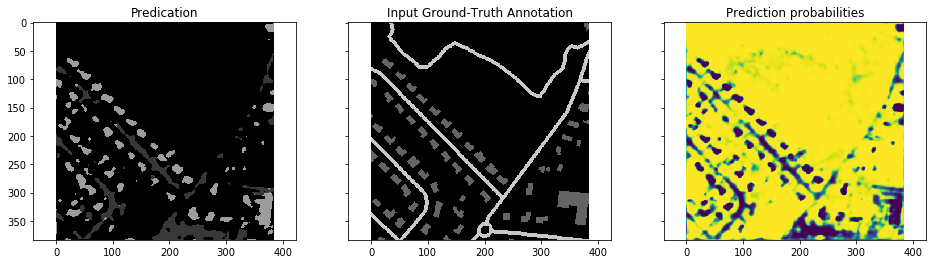

Train step: 87 	Traing Loss: 0.387265


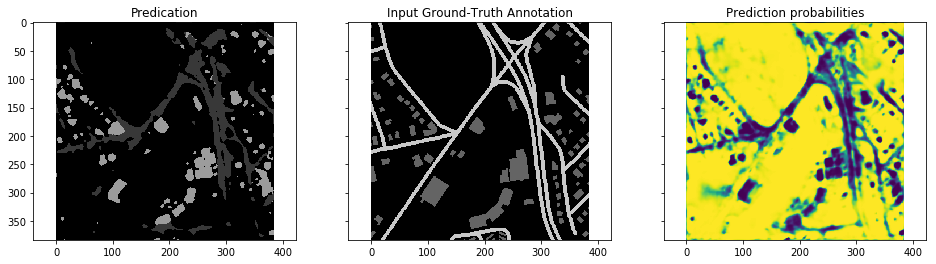

Train step: 88 	Traing Loss: 0.415433


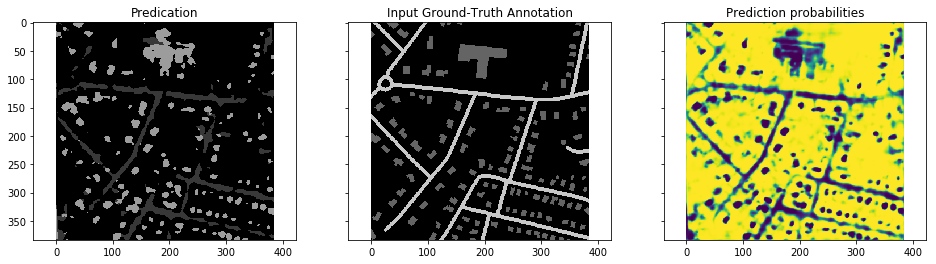

Train step: 89 	Traing Loss: 0.395463


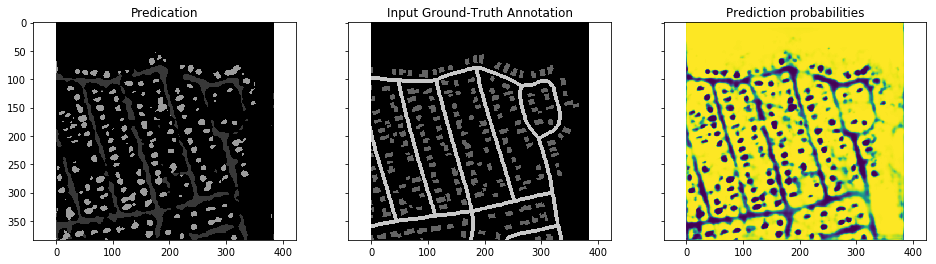

Train step: 90 	Traing Loss: 0.381151


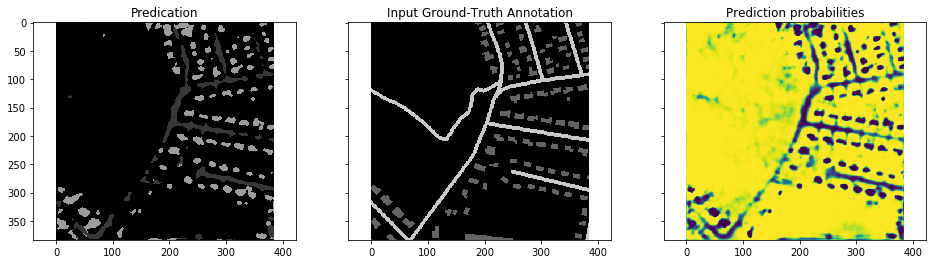

Train step: 91 	Traing Loss: 0.307968


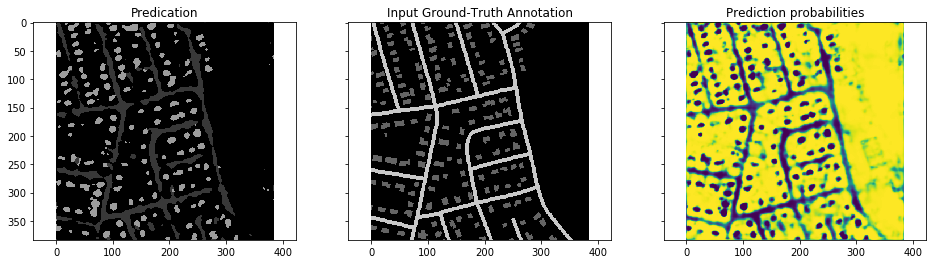

Train step: 92 	Traing Loss: 0.368142


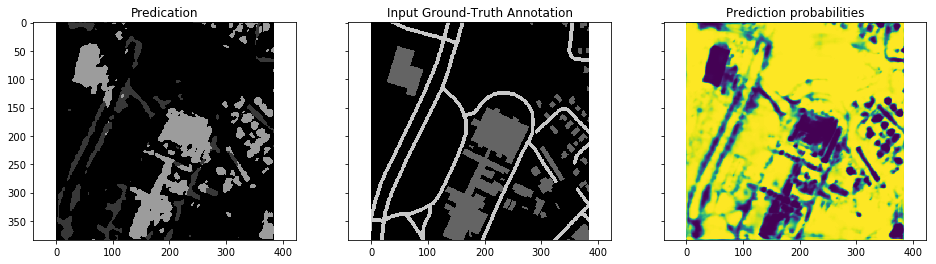

Train step: 93 	Traing Loss: 0.400465


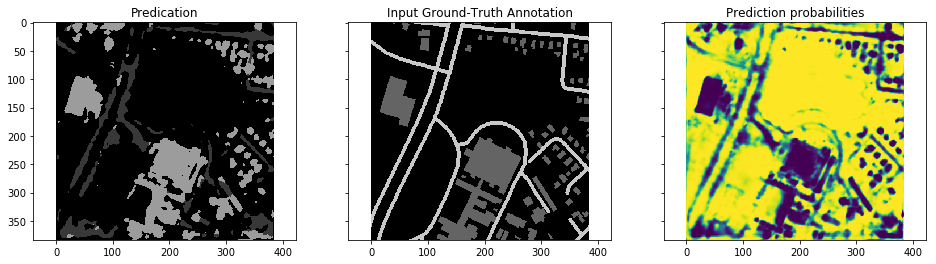

Train step: 94 	Traing Loss: 0.390679


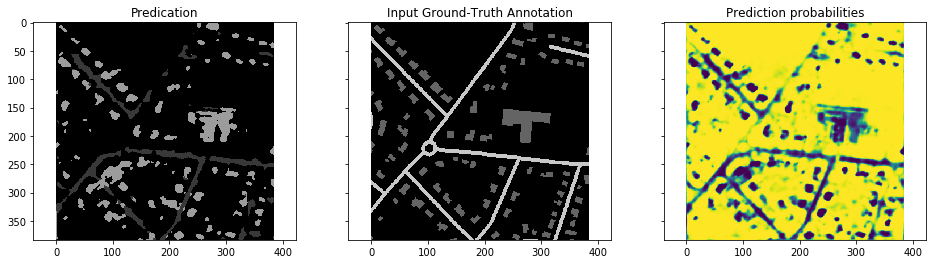

Train step: 95 	Traing Loss: 0.307516


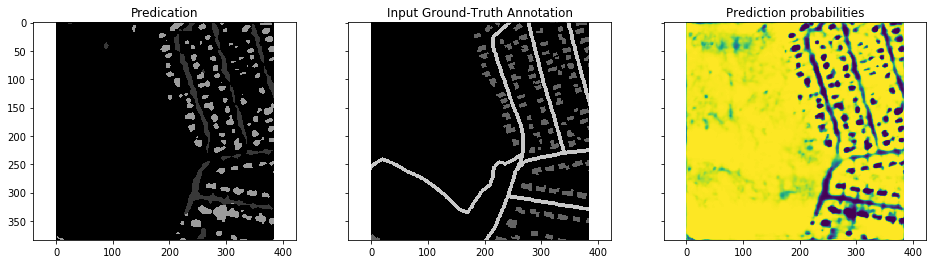

Train step: 96 	Traing Loss: 0.36843


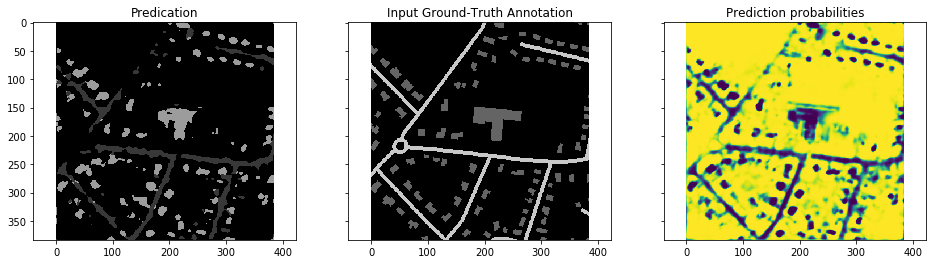

Train step: 97 	Traing Loss: 0.376503


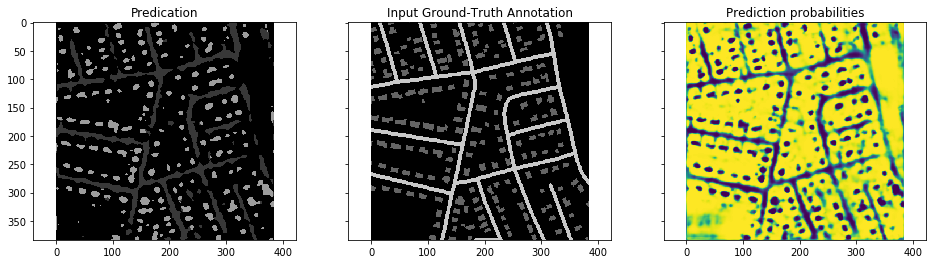

Train step: 98 	Traing Loss: 0.302322


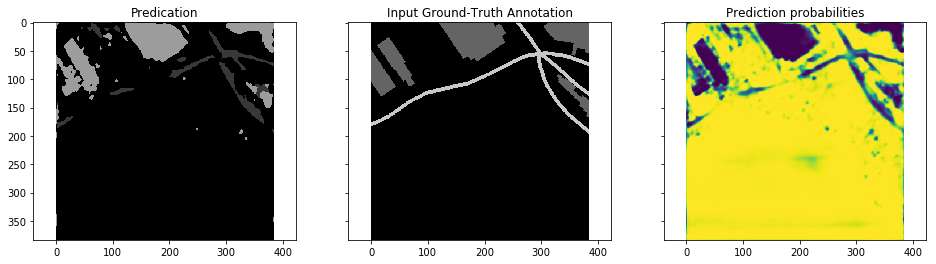

Train step: 99 	Traing Loss: 0.329973


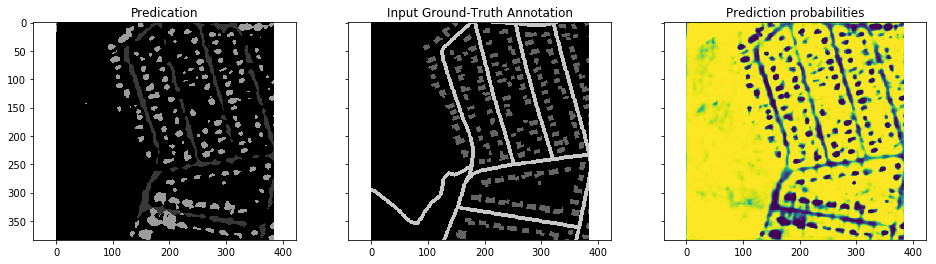

In [29]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    step = 0
    for epoch_id in range(100): 
        for batch_image, batch_annotations in next_batch(train_images_dir, train_annotations_dir, images_filenale_list, 20, crop_size):

            _, train_loss, pred_np, probabilities_np = sess.run([train_step, cross_entropy_sum, pred, probabilities],
                                            feed_dict={input_batch_plc: batch_image, 
                                                       input_masks_plc: batch_annotations,
                                                       is_training_placeholder: True})

            pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
            print("Train step:", step, "\tTraing Loss:", train_loss)
            step += 1
            
        cmap = plt.get_cmap('bwr')
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_figheight(4)
        f.set_figwidth(16)

        ax1.imshow(np.dstack((pred_annotation,)*3)*100)
        ax1.set_title('Predication')
        probability_graph = ax2.imshow(np.dstack((batch_annotations[0],)*3)*100)
        ax2.set_title('Input Ground-Truth Annotation')
        probability_graph = ax3.imshow(probabilities_np[0].squeeze()[:, :, 0])
        ax3.set_title('Prediction probabilities')
        plt.show()

    sess.close()

    summary_string_writer.close()